<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis - Final Project</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Data Collection</h2>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Julia King</h4>
</div>
<br>

In [1]:
# import chunk

# own functions
from common_functions import confirm_execution, read_gtrends_df, write_gtrends_df, read_search_json, write_search_json, read_video_json, write_video_json

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

# youtube api
from pytrends.request import TrendReq
from copy import deepcopy
from requests.exceptions import HTTPError


# 1. Using google trends, determine spikes in public interest concerning 15-minute cities.

In [2]:
# get relevant query term

tr = TrendReq(hl = "en-GB")
suggested_terms = tr.suggestions("15-minute city")
query_list = [suggestion["mid"] for suggestion in suggested_terms if (suggestion["title"] == "15-minute city") and (suggestion["type"] == "Topic")]

query_list

['/g/11hk3_sx0c']

In [3]:
# build payload & obtain interest over time

def get_interest_over_time(trendreq_obj : TrendReq, kw_list : list, timeframe : str, geo : str) -> pd.DataFrame:
    """Given a trendreq object and search queries, returns the google trends interest over time.

    Args:
        trendreq_obj (TrendReq): TrendReq object, allows for preconfigured hl and request_args to avoid TooManyRequestsError
        kw_list (list): list of keywords to get trends for. Must be of length <= 5 due to google trends limit
        timeframe (str): Timeframe in the format "yyyy-mm-dd yyyy-mm-dd" identifying start and end of the timeframe
        geo (str): location code, ex US for USA and DE for Germany

    Returns:
        pd.DataFrame: Object returned by google trends
    """
    
    # make actual request
    trendreq_obj.build_payload(kw_list = kw_list, timeframe = timeframe, geo = geo)
    return trendreq_obj.interest_over_time()

In [4]:
# get interest and save to csv

gtrends_df = get_interest_over_time(tr, kw_list = query_list, timeframe = "2020-01-01 2024-06-30", geo = "US") # kw_list is query term for 15 minute city (topic). Using topic instead of search term to cover variants
gtrends_df["date"] = gtrends_df.index
gtrends_df["volume"] = gtrends_df.iloc[:,0]
gtrends_df = gtrends_df[["date", "volume"]]

# save to csv
write_gtrends_df(gtrends_df)

In [5]:
# load from csv 

gtrends_df = read_gtrends_df()

gtrends_df.head(3)

,date,volume
0,2019-12-29,0
1,2020-01-05,0
2,2020-01-12,0


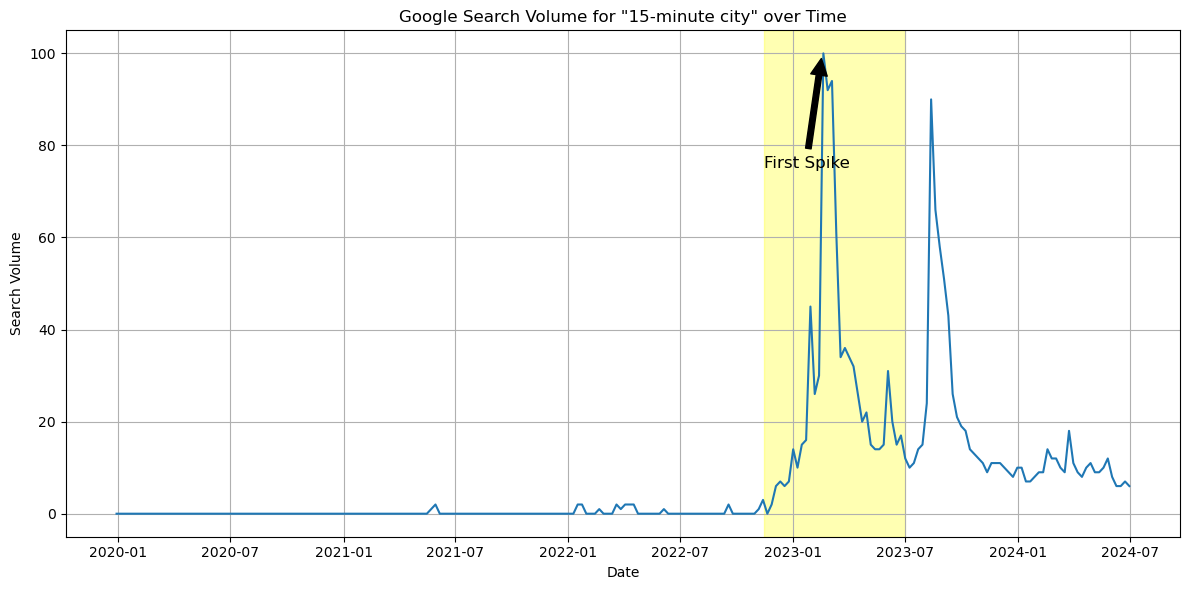

In [6]:
# create plot of google trends

plt.figure(figsize = (12, 6))

plt.plot(gtrends_df["date"], gtrends_df["volume"])

# manual, rough first spike marker
plt.axvspan(pd.to_datetime("2022-11-15"), pd.to_datetime("2023-07-01"), color = "yellow", alpha = 0.3)
plt.annotate("First Spike", xy = (pd.to_datetime("2023-02-17"), gtrends_df.iloc[:, 1].max()),
            xytext = (pd.to_datetime("2022-11-15"), gtrends_df.iloc[:, 1].max() - 25),
            arrowprops = dict(facecolor = "black", shrink = 0.05),
            fontsize = 12)

# Grid, legend + layout
plt.title("Google Search Volume for \"15-minute city\" over Time")
plt.xlabel("Date")
plt.ylabel("Search Volume")
plt.grid(True)
plt.tight_layout()

plt.show()

The plot shows 4 different "phases": 
1. The phase before the first spike, which is hypothesized to contain mostly educational videos on the concept of 15-minute cities.
2. The first spike, which is hypothesized to be caused by content presenting 15-minute cities as a conspiracy.
3. The second spike, which may be caused by mainstream media coverage of the conspiracy theories.
4. The phase after both spikes, where search volume has returned to a steady, if slightly elevated, level.

Thus, to identify the different phases, differences in rolling averages are checked. The splits should occur as follows:
1. The differences turn from ~0 to positive, indicating the beginning of the first spike.
2. The differences turn from negative to neutral and positive again, indicating the end of the first and beginning of the second spike.
3. The differences turn neutral again, indicating the end of the spikes.

In [7]:
# identify 
from scipy.signal import find_peaks

# compute differences in rolling averages
gtrends_df["rolling_mean"] = gtrends_df["volume"].rolling(window = 6, center = False).mean().shift(-5)
gtrends_df["mean_diff"] = gtrends_df["rolling_mean"].diff()

In [8]:
# find peaks, which can then be used to find start (& end) of peaks

peaks = list(find_peaks(gtrends_df["rolling_mean"], 
                        height = gtrends_df["rolling_mean"].quantile(0.9), 
                        distance = 10)[0])

peaks

[164, 189]

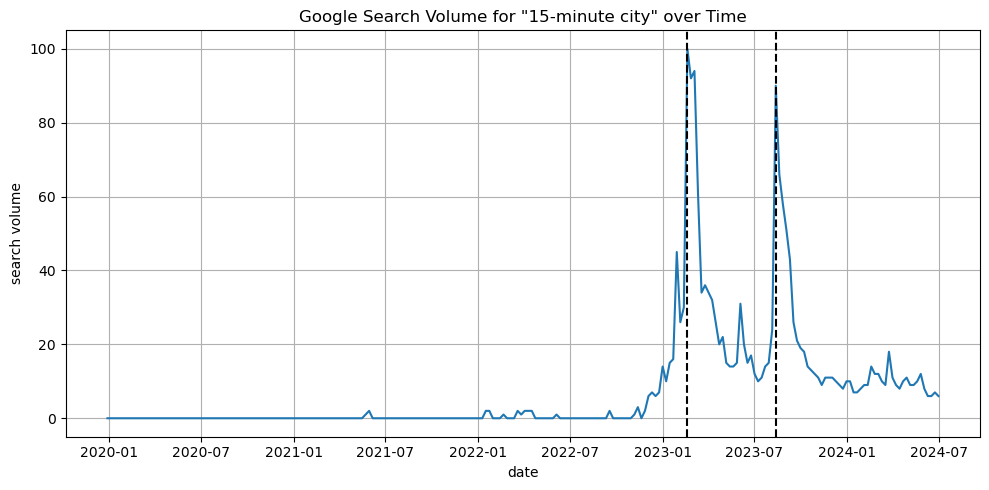

In [9]:
# recreate plot to check validity of peaks

plt.figure(figsize = (10, 5))
plt.plot(gtrends_df["date"], gtrends_df["volume"])

# add peaks
for peak in peaks:
    plt.axvline(x = gtrends_df.loc[peak, "date"], color = "black", linestyle = "--")

# Grid, legend + layout
plt.title("Google Search Volume for \"15-minute city\" over Time")
plt.xlabel("date")
plt.ylabel("search volume")
plt.grid(True)
plt.tight_layout()

plt.show()

In [10]:
# function for finding the first index from a given start point & end point that matches a condition

def find_condition_index(series : pd.Series, condition, min_consecutive : int = 5, start : int = 0, end : int = None) -> int:
    """For a given series and condition, finds the first instance where a specified number of consecutive elements all meet the condition. Useful to identify the beginning / end of peaks.

    Args:
        series (pd.Series): Series to find the condition fulfilled in.
        condition (callable): A function that takes a series & returns true/false for each element if it meets/does not meet the condition.
        start (int, optional): The starting index to begin the search. Defaults to 0.
        end (int, optional): The first index not to be searched any more. Defaults to None (end of the series).
        n (int, optional): The number of consecutive elements that need to meet the condition. Defaults to 5.

    Raises:
        ValueError: If the start index is invalid.
        ValueError: If no suitable index is found where the condition is met for the specified number of consecutive elements.

    Returns:
        int: The index of the first element where the condition is met for it and the following min_consecutive - 1 elements (min_consecutive in total).
    """
    # check input validity
    if (start < 0) or (start > (len(series) - 1)):
        raise ValueError("Not a valid index")
    if (end is None):
        end = len(series)
    
    # find index where it and the next n fulfil the condition
    for i in range(start, min(len(series) - min_consecutive - 1, end)):
        if all(condition(series.iloc[i:i + min_consecutive])):
            return i
    
    # case where no index fits the description
    raise ValueError("No fitting column found.")

In [11]:
# identify start of 1st peak -> differences going from ~0 to significant positive before peaks[0]

phase_starts = [0, find_condition_index(gtrends_df["mean_diff"], condition = lambda x: x > 1, end = peaks[0])]

In [12]:
# identify start of 2nd peak -> differences going from negative to positive after peaks[0] and before peaks[1]

phase_starts.append(find_condition_index(gtrends_df["mean_diff"], condition = lambda x: x > 1, start = peaks[0], end = peaks[1]))

In [13]:
# identify start of 2nd normal phase -> differences going from negative to ~0 after peaks[1]

phase_starts.append(find_condition_index(gtrends_df["mean_diff"], condition = lambda x: abs(x) < 1, start = peaks[1]))

In [14]:
phases = [{"start_index": current, 
           "end_index": next_element - 1, 
           "color": color} for current, next_element, color in zip(phase_starts, 
                                                                   phase_starts[1:] + [len(gtrends_df) - 1], 
                                                                   ["b", "r", "g", "y"])]

In order to prevent imbalanced group sizes and to avoid straining the api too much, the length of phase 1 will be limited to the maximum length of the other phases. This is done by moving the start of phase 1 forward.

In [15]:
# limit phase 1

duration = max(phase["end_index"] - phase["start_index"] for phase in phases[1:])
phases[0]["start_index"] = phases[0]["end_index"] - duration

phases[0]["start_index"]

116

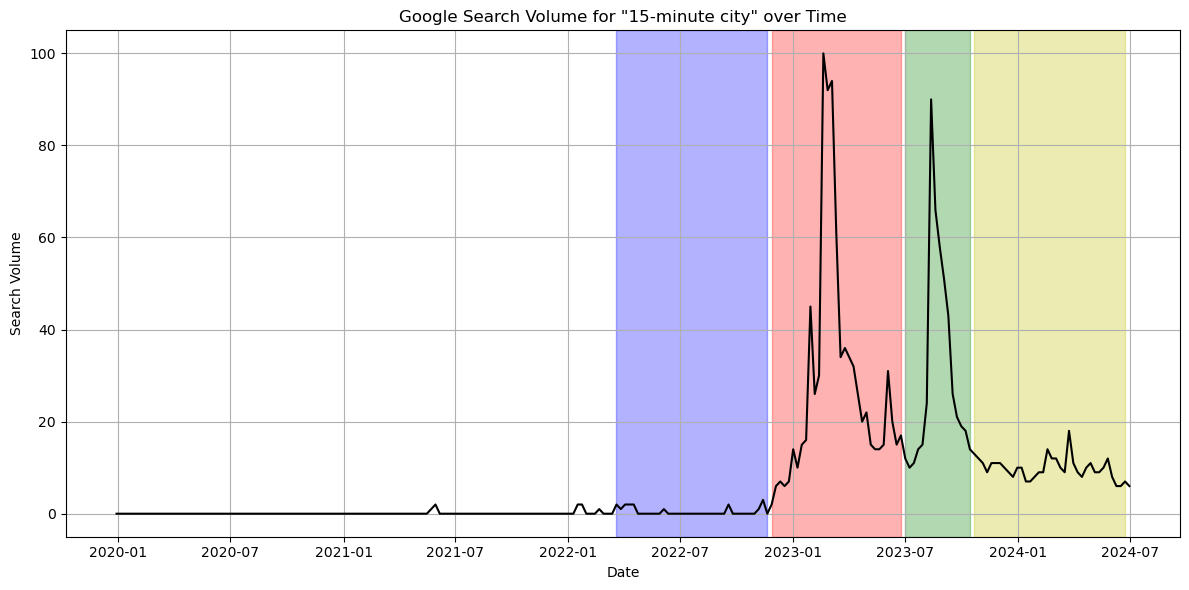

In [16]:
# plot again with the phases

plt.figure(figsize = (12, 6))

plt.plot(gtrends_df["date"], gtrends_df["volume"], color = "black")

# mark the different phases
for sr_phase in phases:
    plt.axvspan(pd.to_datetime(gtrends_df.loc[sr_phase["start_index"], "date"]), gtrends_df.loc[sr_phase["end_index"], "date"], color = sr_phase["color"], alpha = 0.3)

# Grid, legend + layout
plt.title("Google Search Volume for \"15-minute city\" over Time")
plt.xlabel("Date")
plt.ylabel("Search Volume")
plt.grid(True)
plt.tight_layout()

plt.show()

# 2. For the relevant timeframe, obtain the IDs of the most-viewed videos related to 15-minute cities per week.

## 2.1 general setup

In [16]:
# get api key

import api_keys # not included in repository, can be provided in an api_keys.py file
api_key = api_keys.YOUTUBE

In [17]:
# generate a list of weeks for each phase

def generate_weeks(start_date: pd.Timestamp, end_date: pd.Timestamp) -> list:
    """Given a start and end date, generates a list of weeks included in the range. Weeks do not overlap, last week is shortened to only go up to the end date.

    Args:
        start_date (pd.Timestamp): Start of timeframe to generate weeks of. Weeks always start on the weekday of start_date.
        end_date (pd.Timestamp): Where to end timeframe. If this is not either exactly x weeks, 6 days, 23 hours, 59 minutes, 59 seconds OR exactly x weeks, 7 days after start date, then the last week will be shortened. 

    Returns:
        list: List of weeks
    """
    # input validation
    if end_date <= start_date:
        raise ValueError("End date must be greater than start date.")
    
    weeks = []
    current_start = start_date
    
    while current_start <= end_date:
        current_end = current_start + pd.Timedelta(days = 6, hours = 23, minutes = 59, seconds = 59)
        weeks.append((current_start, min(current_end, end_date)))
        current_start = current_start + pd.Timedelta(days = 7)
    
    # Adjust the last tuple if needed
    if weeks and weeks[-1][1] < end_date:
        weeks[-1] = (weeks[-1][0], end_date)
    
    return weeks

# add info to phases list
for sr_phase in phases:
    sr_phase["start_date"] = gtrends_df.loc[sr_phase["start_index"], "date"]
    sr_phase["end_date"] = gtrends_df.loc[sr_phase["end_index"] + 1, "date"] - pd.Timedelta(seconds = 1) # do plus 1 so last week is covered as well
    sr_phase["weeks"] = generate_weeks(sr_phase["start_date"], sr_phase["end_date"])
    
# preview
phases[0]

{'start_index': 116,
 'end_index': 151,
 'color': 'b',
 'start_date': Timestamp('2022-03-20 00:00:00'),
 'end_date': Timestamp('2022-11-26 23:59:59'),
 'weeks': [(Timestamp('2022-03-20 00:00:00'),
   Timestamp('2022-03-26 23:59:59')),
  (Timestamp('2022-03-27 00:00:00'), Timestamp('2022-04-02 23:59:59')),
  (Timestamp('2022-04-03 00:00:00'), Timestamp('2022-04-09 23:59:59')),
  (Timestamp('2022-04-10 00:00:00'), Timestamp('2022-04-16 23:59:59')),
  (Timestamp('2022-04-17 00:00:00'), Timestamp('2022-04-23 23:59:59')),
  (Timestamp('2022-04-24 00:00:00'), Timestamp('2022-04-30 23:59:59')),
  (Timestamp('2022-05-01 00:00:00'), Timestamp('2022-05-07 23:59:59')),
  (Timestamp('2022-05-08 00:00:00'), Timestamp('2022-05-14 23:59:59')),
  (Timestamp('2022-05-15 00:00:00'), Timestamp('2022-05-21 23:59:59')),
  (Timestamp('2022-05-22 00:00:00'), Timestamp('2022-05-28 23:59:59')),
  (Timestamp('2022-05-29 00:00:00'), Timestamp('2022-06-04 23:59:59')),
  (Timestamp('2022-06-05 00:00:00'), Timestam

## 2.2 prepare query parameters & results data structure

This project, especially the search endpoint, will require a lot of requests. Thus, it will be necessary to save partial results and continue on the next day. A JSON structure is used to to this.

In [18]:
# define fixed parameters

search_params_fixed = {"key" : api_key, 
                       "q" : "15-minute city", 
                       "maxResults" : 50, 
                       "order" : "viewcount", 
                       "type" : "video"}

In [ ]:
# define list of dicts which will contain the results from search endpoint

# avoid unintentional resets of the results dataset
confirm_execution("Do you want to reset the results of the search endpoint? ")

search_results = [{week: None for week in phase["weeks"]} for phase in phases] # list structure to keep the phases separate, easier to track later

write_search_json(search_results)

## 2.3 Make search requests

In [ ]:
# load results so far

search_results = read_search_json()

In [ ]:
# define request functions. should requests only those weeks where no data has been generated yet.

def fill_search_phase(phase_results: dict, fixed_params : dict) -> dict:
    """Given the results of a phase, makes requests for every week (/every key) until quota is reached or all weeks are done.

    Args:
        phase_results (dict): dict where keys are tuples of timestamps and values are None for those elements that still need requests.
        fixed_params (dict): parameters to pass on alongside time limits.

    Returns:
        dict: phase results but updated
    """
    
    for daterange, value in phase_results.items():
        if not(value is None): # the request was already successfully obtained, the week can be skipped
            continue
        # prepare params
        current_params = fixed_params.copy()
        current_params["publishedAfter"] = daterange[0].strftime("%Y-%m-%dT%H:%M:%SZ")
        current_params["publishedBefore"] = daterange[1].strftime("%Y-%m-%dT%H:%M:%SZ")
        
        # make request & check validity
        response = requests.get(url = "https://www.googleapis.com/youtube/v3/search", params = current_params)
        if (response.ok):
            phase_results[daterange] = response
        else: # request not successful, likely due to quota constraints
            print(f"Error @ request for week {daterange} with params \n {current_params}.")
            print(f"Errorcode: {response.status_code}, meaning {response.reason}")
            return phase_results
    return phase_results

def fill_search_results(search_results: list, fixed_params : dict) -> list:
    """Given the search results list/json, makes requests for every week until quota is reached. Then returns the search results so they can be saved again. Skips those weeks where a result is already present.

    Args:
        search_results (list): json specified in section above, can already contain some results.
        fixed_params (dict): parameters to pass on alongside time limits.

    Returns:
        list: search_results object filled in as much as possible.
    """
    
    sr_copy = deepcopy(search_results)
    
    for i in range(len(sr_copy)):
        sr_copy[i] = fill_search_phase(sr_copy[i], fixed_params)
    return sr_copy

In [ ]:
# define function that counts number of None entries still left in search results, purely for debugging & user info

def count_none_search(search_results : list) -> int:
    """Given a list of dicts, counts the total number of keys with None values in the dicts.

    Args:
        search_results (list): list of dicts

    Returns:
        int: Nr. of None values in the dicts
    """
    none_count = 0
    for phase_result in search_results:
        none_count = none_count + sum(1 for value in phase_result.values() if value is None)
    return none_count

In [ ]:
# make requests

# avoid unintentional usage of quotas
confirm_execution("Do you want to fill in the remaining search results?")

# count number of nones before to later caluclate change
none_count_before = count_none_search(search_results)

search_results = fill_search_results(search_results, search_params_fixed)

# count number of nones after & print number of entries filled
none_count_after = count_none_search(search_results)

print(f"Nr. of None entries filled: {none_count_before - none_count_after}. Nr. Remaining: {none_count_after}.")

Nr. of None entries filled: 0. Nr. Remaining: 0.


In [ ]:
# function to extract json out of responses (was not done in requests function to minimize chance of errors from anythong other than requests, but is needed to save file as json)

def responses_to_json(search_results : list) -> list:
    """
    Converts all requests.Response objects in the input list to their JSON content.

    Args:
        search_results (list): A list of dictionaries where some values are requests.Response objects.

    Returns:
        list: A list of dictionaries with all requests.Response objects converted to JSON content.
    """      
    sr_copy = deepcopy(search_results)
    for phase_results in sr_copy:
        for daterange, value in phase_results.items():
            if isinstance(value, requests.Response):
                phase_results[daterange] = value.json()
    return sr_copy

In [ ]:
# convert responses to json format

search_results = responses_to_json(search_results)

In [ ]:
# save search results

write_search_json(search_results)

# 3. Obtain relevant metadata and comments for the videos.

## 3.1 Preparing the data structure

Since this is the data i will work with in the end, it will use a flattened structure when compared to the one above: 

video_json will be a list of dicts. Each dict will have the content "phase", "week_start", "video_id", "metadata" and "comments". The end of the week is not stored, as videos with the same week_start have the same week_end.

In [ ]:
# load search results

search_results = read_search_json()

In [ ]:
# create data structure

# avoid unintentional resets of the dataset
confirm_execution("Do you want to reset the results of the video and comment data?")

video_json = []
for phase_nr, phase in enumerate(search_results):
    for week_dates, results in phase.items():
        if results["items"]:  # Some weeks have no videos uploaded. in those weeks, dont add anything to the video_json
            for result in results["items"]:
                video_info = {
                    "phase": phase_nr,
                    "week_start": week_dates[0],
                    "video_id": result["id"]["videoId"],
                    "metadata": None, 
                    "comments": None
                }
                video_json.append(video_info)

write_video_json(video_json)

## 3.2 Requesting Video Information

In [ ]:
# load video data so far

video_json = read_video_json()

In [ ]:
# define fixed parameters
video_params_fixed = {"key" : api_key, 
                      "part" : "contentDetails, id, liveStreamingDetails, localizations, recordingDetails, snippet, statistics, status, topicDetails"} # requested all possible info to make sure i got everything that's needed. this does not increase the quota cost, so i see no reason not to do this.

In [ ]:
# define function that counts number of None entries still left in metadata, purely for debugging & user info

def count_none_video(video_json : list) -> int:
    """Given a list of dicts, counts the total number of dicts where the "metadata" and "comments" keys are filled with None values.

    Args:
        search_results (list): list of dicts

    Returns:
        dict: 2 integers representing the Nr. of dicts with None values in "metadata" and "comments" keys
    """
    none_count = {"metadata" : 0, "comments" : 0}
    for video in video_json:
        if video["metadata"] is None:
            none_count["metadata"] += 1
        if video["comments"] is None:
            none_count["comments"] += 1
    return none_count

In [ ]:
# define request function

def fill_vd_metadata(video_json: dict, fixed_params : dict) -> dict:
    """Given the video data, fills the metadata property of the dicts with request responses until error occurs.

    Args:
        phase_results (dict): list of dicts where each dict contains a "video_id" and a "metadata" to be filled
        fixed_params (dict): parameters to pass on alongside time limits.

    Returns:
        dict: video data but updated
    """
    
    # copy video_json to not accidentally overwrite
    vd_copy = deepcopy(video_json)
    
    to_remove = []
    for i, video in enumerate(vd_copy):
        if not(video["metadata"] is None): # the request was already successfully obtained, the video can be skipped
            continue
        # prepare params
        current_params = fixed_params.copy()
        current_params["id"] = video["video_id"]
        
        # make request & check validity
        response = requests.get(url = "https://www.googleapis.com/youtube/v3/videos", params = current_params)
        if not(response.ok): # request not successful, likely due to quota constraints
            print(f"Error @ request for video {i} with id \n {current_params["id"]}.")
            print(f"Errorcode: {response.status_code}, meaning {response.reason}")
            break
        
        # response is valid
        # now extract the video data from the response
        resp_json = response.json() # converting within the function this time, as each call only requires 1 token instead of 100 in search, so mistakes are less costly
        
        # check if video data was obtained. if not, remove the video from the list. this can occur if the uploader deleted the video
        if (len(resp_json["items"]) == 0):
            to_remove.append(i)
        else:
            vd_copy[i]["metadata"] = resp_json["items"][0]
        print(f"Video with id {video["video_id"]} done!")
        
    # remove all videos that were found to be unavailable & return
    vd_copy_filtered = [video for index, video in enumerate(vd_copy) if index not in to_remove] 
    return vd_copy_filtered

In [ ]:
# run function

confirm_execution("Do you want to fill in the remaining video metadata as much as possible?")

# count number of nones before to later caluclate change
none_count_before = count_none_video(video_json)["metadata"]

video_json = fill_vd_metadata(video_json, fixed_params = video_params_fixed)

# count number of nones after & print number of entries filled
none_count_after = count_none_video(video_json)["metadata"]

print(f"Nr. of None entries filled: {none_count_before - none_count_after}. Nr. Remaining: {none_count_after}.")

Nr. of None entries filled: 0. Nr. Remaining: 0.


In [ ]:
# save metadata results

write_video_json(video_json)

## 3.3 Comments

In [ ]:
# load video data so far

video_json = read_video_json()

In [ ]:
# some videos will have no comments due to being assigned as "for kids" (or similar). In these cases, the api will return a 403: forbidden. 
# This is the same code that you get if the quota limit is hit, meaning i cannot automatically filter the two scenarios.
# Thus, i will just assign an empty list to the "comments" attribute for the videos with 0 comments.
# This will automatically cause them to not be requested.

for i, video in enumerate(video_json):
    statistics = video["metadata"]["statistics"]
    if "commentCount" not in statistics:
        statistics["commentCount"] = "0"
    if int(statistics["commentCount"]) == 0:
        video_json[i]["comments"] = {}

In [ ]:
# define fixed parameters
comment_params_fixed = {"key" : api_key, 
                      "part" : "id, replies, snippet", # requested all possible info to make sure i got everything that's needed. this does not increase the quota cost, so i see no reason not to do this.
                      "maxResults" : 100, # max possible value
                      "order" : "time", # other option was time, but that wouldnt 
                      "textFormat" : "plainText"} 

In [ ]:
# the comments need to be requested in multiple pages. thus, one inner and one outer function are written. 
# inner function gets all comments for one video. outer function loops over the list and calls inner function for each video.
# analysis was limited to top-level comments, as the aim of the analysis is to see the effect of the content type on the comments. thus, lower-level comments would be biased based on the tone of the top-level comment.
# further, grabbing all comments was infeasible due to api constraints

def get_toplevel_comments(video_id : str, fixed_params : dict) -> list:
    """Given a video id and parameters (including api key), returns all top-level comments of said video

    Args:
        video_id (str): video id of a youtube video
        fixed_params (dict): should include at least the api key and part options given by youtube api

    Returns:
        list: list of all top-level comments
    """
    
    # prepare params
    params = fixed_params.copy()
    params["videoId"] = video_id
    
    # gather comments
    comments = {}
    while True:
        # get request & check validity. Raise error if invalid response.
        response = requests.get(url = "https://www.googleapis.com/youtube/v3/commentThreads", params = params)
        if not(response.ok): 
            raise HTTPError(f"Error @ request for comments of video_id \n {video_id}. Errorcode: {response.status_code}, meaning {response.reason}")
            # comments are purposefully not returned here, as i only want to save completed comment collections.
        
        # request received valid response, extract top comments and append comments dict
        resp_json = response.json()
        new_comments = {thread["snippet"]["topLevelComment"]["id"] : thread["snippet"]["topLevelComment"]["snippet"]["textDisplay"] for thread in resp_json["items"]}
        comments.update(new_comments)
        
        # check if current response completed the comment dict.
        if "nextPageToken" in resp_json: # current comment "page" is not the last one -> update pageToken and loop once again
            params["pageToken"] = resp_json["nextPageToken"]
        else: # last page is reached and integrated, comments can be returned.
            return comments

def fill_vd_comments(video_json: dict, fixed_params : dict) -> dict:
    """Given the video data, fills the comments property of the dicts with request responses until error occurs.

    Args:
        phase_results (dict): list of dicts where each dict contains a "video_id" and a "comments" key to be filled
        fixed_params (dict): parameters to pass on alongside time limits.

    Returns:
        dict: video data but updated
    """
    
    # copy video_json to not accidentally overwrite
    vd_copy = deepcopy(video_json)
    
    for i, video in enumerate(vd_copy):
        if not(video["comments"] is None): # the request was already successfully obtained, the video can be skipped
            continue
        try:
            vd_copy[i]["comments"] = get_toplevel_comments(video["video_id"], fixed_params)
            print(f"Video with id {video["video_id"]} done!")
        except HTTPError as e: # usually means quota limit was reached. Intermediate results are returned so the function can continue on the next day.
            print(f"HTTP Error occurred for video_id {video["video_id"]}: {e}")
            return vd_copy  # Return the results processed so far
        except Exception as e:
            print(f"Unexpected error occurred for video_id {video["video_id"]}: {e}")
            return vd_copy  # Return the results processed so far
    return vd_copy

In [ ]:
# run function

confirm_execution("Do you want to fill in the remaining video comments as much as possible?")

# count number of nones before to later caluclate change
none_count_before = count_none_video(video_json)["comments"]

video_json = fill_vd_comments(video_json, fixed_params = comment_params_fixed)

# count number of nones after & print number of entries filled
none_count_after = count_none_video(video_json)["comments"]

print(f"Nr. of None entries filled: {none_count_before - none_count_after}. Nr. Remaining: {none_count_after}.")

Video with id 59hedeEa7_A done!
Video with id 3BZfVBxIvQs done!
Video with id reFg5h8KM-4 done!
Video with id GR7XL52jI6Q done!
Video with id bHrOI9Qss5o done!
Video with id 1V5EtcHrXno done!
Video with id _E_vlehr-cY done!
Video with id GlGVU8ZfSLY done!
Video with id cINJp7CAJlQ done!
Video with id fL3kBh2RuCU done!
Video with id gxtH-YUyxCk done!
Video with id JCs7sn5-kAg done!
Video with id dAq6Rh7wzyg done!
Video with id QcNnT0dyiKU done!
Video with id BB1MumAMpBc done!
Video with id dynk2jc6M34 done!
Video with id iYWUHyf6yCE done!
Video with id QDJE8XzfihE done!
Video with id 4TldD5umZkM done!
Video with id aGKYh1VdqSo done!
Video with id j0U1g7rNBco done!
Video with id Yl5KPiZLJAY done!
Video with id tRGbkkZ-_Uc done!
Video with id t2SyjKf6nJ8 done!
Video with id bYwryFB649Y done!
Video with id vOAYO0rINhk done!
Video with id dkLurfDNJfE done!
Video with id oIyTWXKNVt8 done!
Video with id AP0ZjuzmSso done!
Video with id y6N1srpZ-zg done!
Video with id mUDM0G49H8Q done!
Video wi

In [ ]:
# save metadata results

write_video_json(video_json)